### Instacart Market Basket Analysis ###

This data was open sourced from Instacart directly in 2017.  It is comprised of roughly 3.2 million Instacart Orders (customer information has been anonymized).  The goal for the original kaggle challenge was to leverage the customers orders placed over time, to predict which of the previously purchased products will be purchased in their next order.

Full citation for the dataset:  jeremy stanley, Meg Risdal, sharathrao, and Will Cukierski. Instacart Market Basket Analysis. https://kaggle.com/competitions/instacart-market-basket-analysis, 2017. Kaggle.

I will leverage the orders_prior dataframe to perform customer segmentation via k-means clustering.

In [1]:
#import packages
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import scipy
import os

The data for this project is stored in several files.  Below is the data dictionary supplied by the kaggle publisher of the dataset [jeremystan](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b): 

`orders` (3.4m rows, 206k users):
* `order_id`: order identifier
* `user_id`: customer identifier
* `eval_set`: which evaluation set this order belongs in (see `SET` described below)
* `order_number`: the order sequence number for this user (1 = first, n = nth)
* `order_dow`: the day of the week the order was placed on
* `order_hour_of_day`: the hour of the day the order was placed on
* `days_since_prior`: days since the last order, capped at 30 (with NAs for `order_number` = 1)

`products` (50k rows):
* `product_id`: product identifier
* `product_name`: name of the product
* `aisle_id`: foreign key
* `department_id`: foreign key

`aisles` (134 rows):
* `aisle_id`: aisle identifier
* `aisle`: the name of the aisle

`deptartments` (21 rows):
* `department_id`: department identifier
* `department`: the name of the department

`order_products__SET` (30m+ rows):
* `order_id`: foreign key
* `product_id`: foreign key
* `add_to_cart_order`: order in which each product was added to cart
* `reordered`: 1 if this product has been ordered by this user in the past, 0 otherwise

where `SET` is one of the four following evaluation sets (`eval_set` in `orders`):
* `"prior"`: orders prior to that users most recent order (~3.2m orders)
* `"train"`: training data supplied to participants (~131k orders)
* `"test"`: test data reserved for machine learning competitions (~75k orders)

In [2]:
# load orders to dataframe in order to split between "prior", "train" and "test" sets
orders_df = pd.read_csv('../raw_data_files/orders.csv') 
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [3]:
set_counts = orders_df.groupby(['eval_set']).count()
set_counts

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
eval_set,,,,,,
prior,3214874,3214874,3214874,3214874,3214874,3008665
test,75000,75000,75000,75000,75000,75000
train,131209,131209,131209,131209,131209,131209


In [4]:
#split orders into "prior", "train" and "test" sets
orders_prior_df = orders_df[orders_df['eval_set']=="prior"]
orders_train_df = orders_df[orders_df['eval_set']=="train"]
orders_test_df = orders_df[orders_df['eval_set']=="test"]
#test splits to ensure we have the correct number of records indicated above
set_counts_prior = orders_prior_df['order_id'].count()
set_counts_train = orders_train_df['order_id'].count()
set_counts_test = orders_test_df['order_id'].count()
print("prior: ", set_counts_prior)
print("test: ", set_counts_test)
print("train: ", set_counts_train)


prior:  3214874
test:  75000
train:  131209


In [5]:
orders_prior_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3214874 entries, 0 to 3421081
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 196.2+ MB


All columns appear to have appropriate Dtypes.  No changes updates appear to be needed.

In [6]:
#import order_products_prior data
order_prod_prior_df = pd.read_csv('../raw_data_files/order_products__prior.csv') 
order_prod_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
order_prod_prior_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


In [8]:
#merge orders and order_prod_prior into orders dataframe for prior orders
combo_order_prod_prior_df = order_prod_prior_df.merge(orders_df, on='order_id')
combo_order_prod_prior_df.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0
5,2,17794,6,1,202279,prior,3,5,9,8.0
6,2,40141,7,1,202279,prior,3,5,9,8.0
7,2,1819,8,1,202279,prior,3,5,9,8.0
8,2,43668,9,0,202279,prior,3,5,9,8.0
9,3,33754,1,1,205970,prior,16,5,17,12.0


In [9]:
combo_order_prod_prior_df[['order_id', 'product_id', 'user_id']].nunique()

order_id      3214874
product_id      49677
user_id        206209
dtype: int64

In [10]:
combo_order_prod_prior_df.describe().round(2)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,32434489.00,32434489.00,32434489.00,32434489.00,32434489.00,32434489.00,32434489.00,32434489.00,30356421.00
mean,1710748.52,25576.34,8.35,0.59,102937.24,17.14,2.74,13.42,11.10
std,987300.70,14096.69,7.13,0.49,59466.48,17.54,2.09,4.25,8.78
min,2.00,1.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,855943.00,13530.00,3.00,0.00,51421.00,5.00,1.00,10.00,5.00
50%,1711048.00,25256.00,6.00,1.00,102611.00,11.00,3.00,13.00,8.00
75%,2565514.00,37935.00,11.00,1.00,154391.00,24.00,5.00,16.00,15.00
max,3421083.00,49688.00,145.00,1.00,206209.00,99.00,6.00,23.00,30.00


The data overview, stated that there would be a maximum of 100 orders therefore the values appear to be inline; but we may want to check for outliers here as this could skew the results. The order_dow corresponds to days of the week.  Therefore that also appears to be inline given the range of 0-6.  The data overview doesn't provide a dictionary for which value corresponds to which day of the week.  Likewise, for days_since_prior_order the overview specified that they only tracked up to 30 days since the previous order.  The field called add_to_cart_order refers to the actual order in which a product was added to the cart.  We will look for potential outliers here, as the max is 145 items.  We will now check for missing values.

In [11]:
#data appears to be complete, but will double check that there are no missing values
missing_order = combo_order_prod_prior_df.isnull().sum()  #count missing values
missing_order

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
dtype: int64

The data overview specifically noted that any NaN values within the days_since_prior_order field represents no orders within the last 30 days.  We will leave it as is, since it 
doesn't make sense to impute a value here.

We will now plot the distributions of the features.

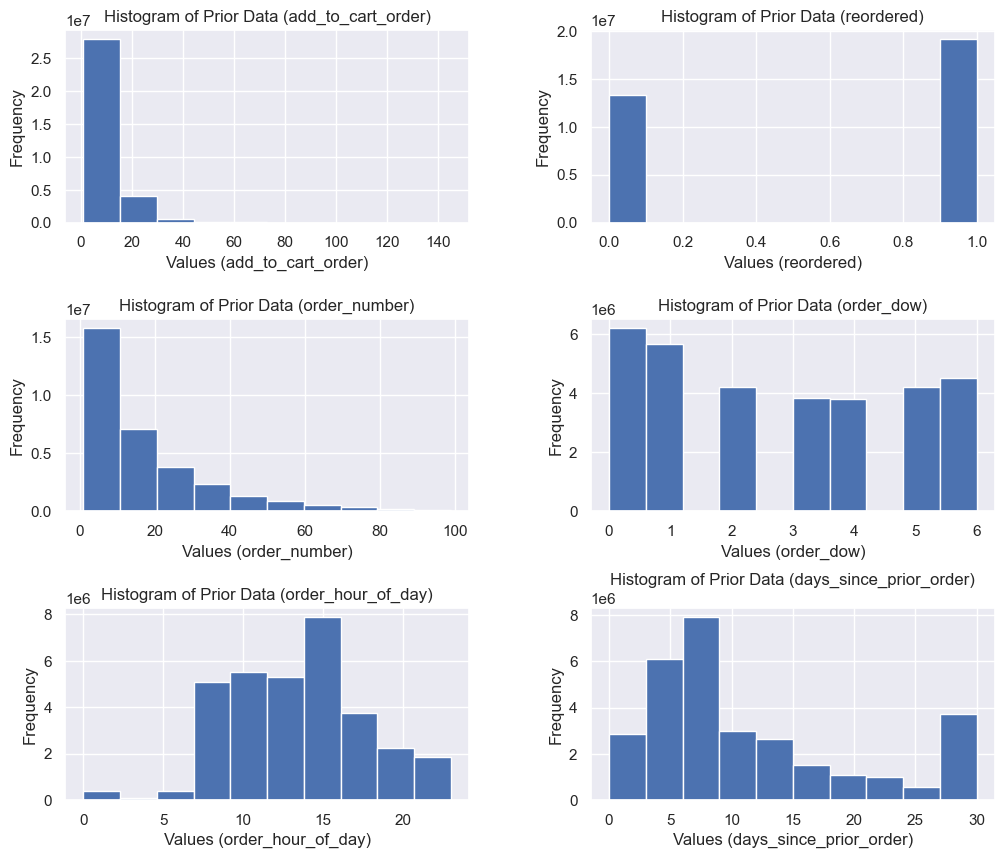

In [30]:
#remove unnecessary columns and create temp df
drop_columns = ['order_id', 'product_id', 'user_id', 'eval_set']
df = combo_order_prod_prior_df.drop(columns=drop_columns)

#create histograms for each of the remaining columns
fig, axs = plt.subplots(3,2, figsize=(12,10))
columns = df.columns

for ax, col in zip(axs.ravel(), columns):
    df[col].hist(ax=ax, bins=10)
    ax.set_title(f'Histogram of Prior Data ({col})')
    ax.set_xlabel(f'Values ({col})')
    ax.set_ylabel('Frequency')

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

In [20]:
# filter to orders with more than 30 (roughly mean + 3 std deviations) items in the purchase
orders_more_than_30_items = combo_order_prod_prior_df[combo_order_prod_prior_df['add_to_cart_order']>30]
print("Number of unique order IDs with more than 30 items:" , orders_more_than_30_items.order_id.nunique())
print("Number of unique customer IDs with orders containing more than 30 items:" , orders_more_than_30_items.user_id.nunique())

orders_more_than_50_items = combo_order_prod_prior_df[combo_order_prod_prior_df['add_to_cart_order']>50]
print("Number of unique order IDs with more than 50 items:" , orders_more_than_50_items.order_id.nunique())
print("Number of unique customer IDs with orders containing more than 50 items:" , orders_more_than_50_items.user_id.nunique())


Number of unique order IDs with more than 30 items: 65672
Number of unique customer IDs with orders containing more than 30 items: 22168
Number of unique order IDs with more than 50 items: 3081
Number of unique customer IDs with orders containing more than 50 items: 1628


For now, I will keep the complete transaction set as I will be segmenting the customers based on the number of orders placed, how recently they placed those orders and the number of avg. number of items purchased in each order.  

I will also apply the same modifications to the train data set.

In [21]:
#import order_products_train data
order_prod_train_df = pd.read_csv('../raw_data_files/order_products__train.csv') 
order_prod_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [22]:
order_prod_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB


In [23]:
#merge orders and order_prod_train into orders dataframe for training set orders
combo_order_prod_train_df = order_prod_train_df.merge(orders_df, on='order_id')
combo_order_prod_train_df.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,112108,train,4,4,10,9.0
1,1,11109,2,1,112108,train,4,4,10,9.0
2,1,10246,3,0,112108,train,4,4,10,9.0
3,1,49683,4,0,112108,train,4,4,10,9.0
4,1,43633,5,1,112108,train,4,4,10,9.0
5,1,13176,6,0,112108,train,4,4,10,9.0
6,1,47209,7,0,112108,train,4,4,10,9.0
7,1,22035,8,1,112108,train,4,4,10,9.0
8,36,39612,1,0,79431,train,23,6,18,30.0
9,36,19660,2,1,79431,train,23,6,18,30.0


In [24]:
combo_order_prod_train_df[['order_id', 'product_id', 'user_id']].nunique()

order_id      131209
product_id     39123
user_id       131209
dtype: int64

In [25]:
combo_order_prod_train_df.describe().round(2)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,1384617.00,1384617.00,1384617.00,1384617.00,1384617.00,1384617.00,1384617.00,1384617.00,1384617.00
mean,1706297.62,25556.24,8.76,0.60,103112.78,17.09,2.70,13.58,17.07
std,989732.65,14121.27,7.42,0.49,59487.15,16.61,2.17,4.24,10.43
min,1.00,1.00,1.00,0.00,1.00,4.00,0.00,0.00,0.00
25%,843370.00,13380.00,3.00,0.00,51732.00,6.00,1.00,10.00,7.00
50%,1701880.00,25298.00,7.00,1.00,102933.00,11.00,3.00,14.00,15.00
75%,2568023.00,37940.00,12.00,1.00,154959.00,21.00,5.00,17.00,30.00
max,3421070.00,49688.00,80.00,1.00,206209.00,100.00,6.00,23.00,30.00


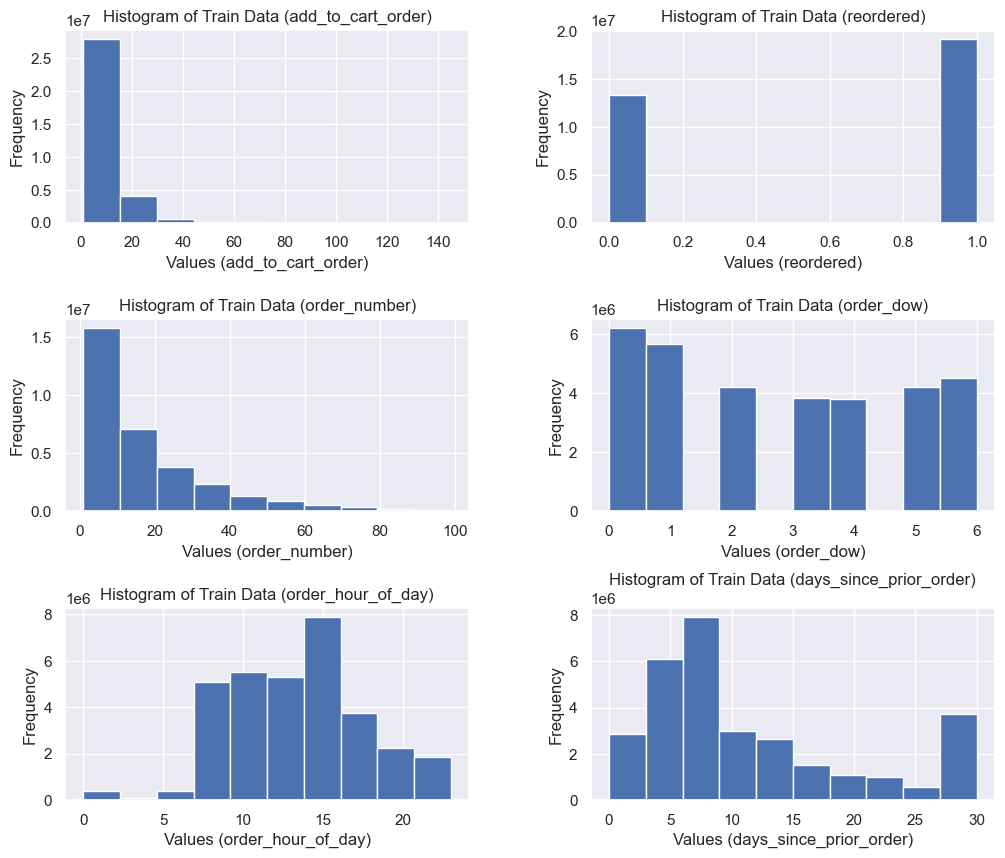

In [31]:
drop_columns = ['order_id', 'product_id', 'user_id', 'eval_set']
df2 = combo_order_prod_train_df.drop(columns=drop_columns)

#create histograms for each of the remaining columns
fig, axs = plt.subplots(3,2, figsize=(12,10))
columns = df2.columns

for ax, col in zip(axs.ravel(), columns):
    df[col].hist(ax=ax, bins=10)
    ax.set_title(f'Histogram of Train Data ({col})')
    ax.set_xlabel(f'Values ({col})')
    ax.set_ylabel('Frequency')

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()


In [32]:
# import products, aisle and department data
products_df = pd.read_csv('../raw_data_files/products.csv')
aisles_df = pd.read_csv('../raw_data_files/aisles.csv') 
departments_df = pd.read_csv('../raw_data_files/departments.csv') 
print(products_df.info())
print(aisles_df.info())
print(departments_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     o

All columns in the product, aisle and department tables appear to have appropriate Dtypes.  No changes or updates appear to be needed.

In [33]:
#merge product dataframe with aisle and department dataframes
combo_prod_df = products_df.merge(departments_df, on='department_id')\
    .merge(aisles_df, on='aisle_id')
    
combo_prod_df.head(10)

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation
5,6,Dry Nose Oil,11,11,personal care,cold flu allergy
6,7,Pure Coconut Water With Orange,98,7,beverages,juice nectars
7,8,Cut Russet Potatoes Steam N' Mash,116,1,frozen,frozen produce
8,9,Light Strawberry Blueberry Yogurt,120,16,dairy eggs,yogurt
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7,beverages,water seltzer sparkling water


In [34]:
combo_prod_df[['department_id', 'aisle_id']].nunique()

department_id     21
aisle_id         134
dtype: int64

In [35]:
combo_prod_df.describe().round(2)

,product_id,aisle_id,department_id
count,49688.00,49688.00,49688.00
mean,24844.50,67.77,11.73
std,14343.83,38.32,5.85
min,1.00,1.00,1.00
25%,12422.75,35.00,7.00
50%,24844.50,69.00,13.00
75%,37266.25,100.00,17.00
max,49688.00,134.00,21.00


In [36]:
#We will review for missing values
missing_product = combo_prod_df.isnull().sum()  #count missing values
missing_product

product_id       0
product_name     0
aisle_id         0
department_id    0
department       0
aisle            0
dtype: int64

All fields are complete. No missing values in the product tables.

In [37]:
#export final combo_order_product tables (no prod, aisle, dept names)
combo_order_prod_prior_df.to_csv('../cleaned_data_files/combo_order_prod_prior.csv', index=False)
combo_order_prod_train_df.to_csv('../cleaned_data_files/combo_order_prod_train.csv', index=False)

#export final product table
combo_prod_df.to_csv('../cleaned_data_files/combo_prod.csv', index=False)